# Evaluation of model performance

Evaluation...  

...  

...  


...

In [14]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from torch.utils.data import DataLoader
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split,KFold

from src.data.data_scaler import PreProcess
from src.data.data_loader import MIMICDataset,import_data,collate_fn_padd
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN,LatentODE1,ODEGRU
from src.utils import seed_everything

In [2]:
import scipy

In [3]:
import plotnine as p9

In [4]:
from data.feature_sets import all_features,glycaemic_features

In [5]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [6]:
preproc = PreProcess(all_features(),QuantileTransformer())
df_train = pd.read_csv('data/train.csv')
preproc.fit(df_train)

## Import model

In [13]:
model_path = 'experiments/mimic/ODEGRU.pth'
cpt = torch.load(model_path)

In [17]:
model = ODEGRU(25, 12, 0.1, 1,128,"cpu").to("cpu")

In [18]:
model.load_state_dict(cpt['state_dict'])

<All keys matched successfully>

In [19]:
model

ODEGRU(
  (rnn): GRUCell(25, 12)
  (func): ODEGRU_(
    (net): Sequential(
      (0): Linear(in_features=38, out_features=18, bias=True)
      (1): Tanh()
      (2): Linear(in_features=18, out_features=12, bias=True)
      (3): Tanh()
    )
  )
  (relu): ReLU()
  (l1): Linear(in_features=12, out_features=6, bias=True)
  (distribution_mu): Linear(in_features=6, out_features=1, bias=True)
  (sigma_net): Sequential(
    (0): Linear(in_features=12, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

## Import test data

In [20]:
df_test = import_data("data/test.csv")
print(df_test.shape)

(78557, 112)


In [22]:
df_test = preproc.transform(df_test)

In [23]:
df_test['dt'] = df_test.timer_dt - df_test.timer

## Check

In [24]:
tmp = MIMICDataset(df_test,glycaemic_features(),verbose=False)

In [25]:
glc_transform(np.array([198.,189.]))

array([0.34662461, 0.30010459])

In [26]:
x, y, msk, dt, msk0 = tmp[0]
print(ginv(x[0,0]))
x[0,1] = 0.0
for dt_ in np.linspace(0,3,10):
    dt[0,1] = dt[0,0] + dt_
    print(ginv(model.forward(torch.tensor(dt).unsqueeze(0),torch.tensor(x).unsqueeze(0))[0][0,0].detach().numpy()))

0.3466245914060298
[93.12158]
[92.80299]
[92.491455]
[92.18685]
[91.88903]
[91.59798]
[91.31361]
[91.03584]
[90.76459]
[90.49989]


# Predict

In [27]:
dl_test = DataLoader(MIMICDataset(df_test,glycaemic_features()),batch_size=256,collate_fn=collate_fn_padd)
dataloaders = {'test':dl_test}
loss_test,error_tests,y_preds,y_tests,msks = model.evaluate(dataloaders["test"])

reconfiguring data...
excluded patients: 0
excluded rows: 0


100%|██████████| 17/17 [00:13<00:00,  1.27it/s]

_rmse : 89.322
_loss : 40.961


In [28]:
y_obs = df_test.loc[df_test.msk==0,'glc_dt'].to_numpy()

In [29]:
y_obs.shape[0]

71414

In [30]:
mu,sig = model.predict(dataloaders["test"])
print(mu.shape)
print(sig.shape)

(71414,)
(71414,)


In [35]:
mu_preds = []

In [36]:
print(df_test.loc[df_test.msk==0].shape)

(71414, 113)


(array([1.6610e+03, 1.0240e+04, 3.4759e+04, 1.9091e+04, 4.4780e+03,
        1.1370e+03, 4.7000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.8210383 , -0.52967054, -0.23830275,  0.05306502,  0.3444328 ,
         0.6358006 ,  0.92716837,  1.2185361 ,  1.5099039 ,  1.8012717 ,
         2.0926394 ], dtype=float32),
 <BarContainer object of 10 artists>)

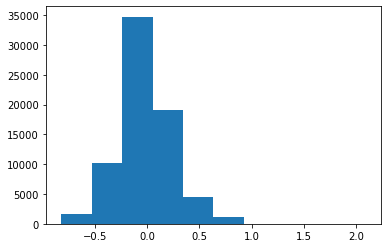

In [37]:
plt.hist(mu)

## Evaluate

text

In [31]:
df_test.loc[df_test.msk==0,'mu'] = mu
df_test.loc[df_test.msk==0,'sig'] = sig

In [32]:
df_test['lower80'] = df_test['mu'] - 1.281552*df_test['sig']
df_test['upper80'] = df_test['mu'] + 1.281552*df_test['sig']
df_test['lower95'] = df_test['mu'] - 1.959964*df_test['sig']
df_test['upper95'] = df_test['mu'] + 1.959964*df_test['sig']
df_test['lower99'] = df_test['mu'] - 3.290527*df_test['sig']
df_test['upper99'] = df_test['mu'] + 3.290527*df_test['sig']

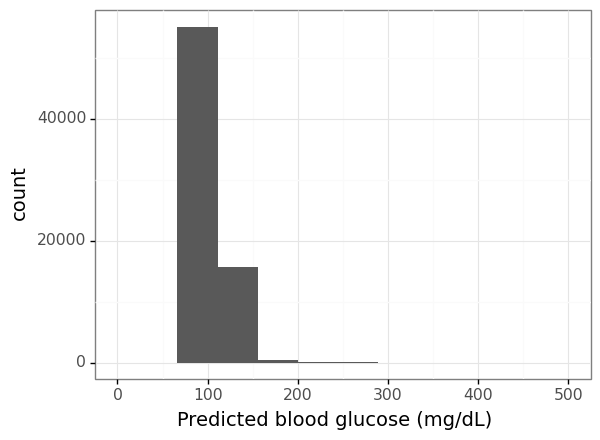

<ggplot: (8777821759585)>

In [33]:
(
    p9.ggplot(df_test.loc[df_test.msk==0],p9.aes(x='ginv(mu)')) + 
    p9.geom_histogram(bins=100) + 
    p9.coord_cartesian(xlim=(0,500)) +
    p9.labs(x="Predicted blood glucose (mg/dL)") +
    p9.theme_bw(base_size=14)
)

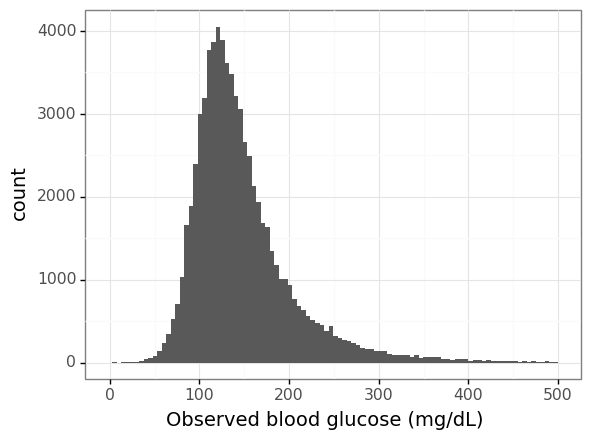

<ggplot: (8788766355065)>

In [41]:
(
    p9.ggplot(df_test.loc[df_test.msk==0],p9.aes(x='ginv(glc_dt)')) + 
    p9.geom_histogram(bins=100) + 
    p9.labs(x="Observed blood glucose (mg/dL)") +
    p9.theme_bw(base_size=14)
)

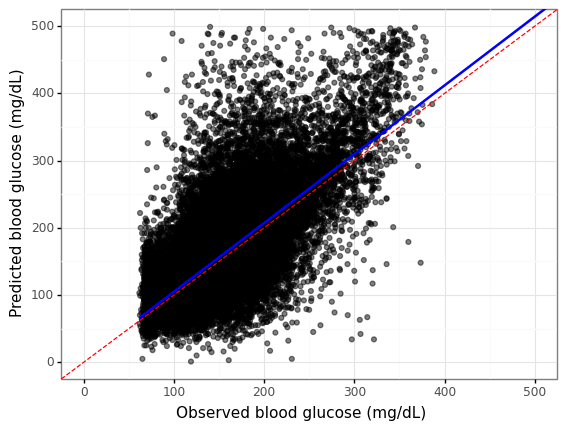

<ggplot: (8788766249645)>

In [42]:
(
    p9.ggplot(df_test.loc[df_test.msk==0],p9.aes(x='ginv(mu)',y='ginv(glc_dt)')) + 
    p9.geom_point(alpha=0.5) + 
    p9.geom_smooth(color="blue") +
    p9.geom_abline(intercept=0,slope=1,linetype="dashed",color="red") +
    p9.coord_cartesian(xlim=(0,500),ylim=(0,500)) +
    p9.labs(x="Observed blood glucose (mg/dL)",y= "Predicted blood glucose (mg/dL)") +
    p9.theme_bw()
)

In [43]:
res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

coverage of 80% prediction interval: 0.8181
coverage of 95% prediction interval: 0.9310
coverage of 99% prediction interval: 0.9843


In [44]:
N = 12
max_t = 12
conf_res = pd.DataFrame({
    "dt0" : np.linspace(0,max_t-1,N),
    "dt1" : np.linspace(1,max_t,N),
    "cov80" : np.zeros(N),
    "cov95" : np.zeros(N),
    "cov99" : np.zeros(N)
})
for i in range(conf_res.shape[0]):
    msk = (df_test.msk==0) & (df_test.dt >= conf_res.dt0[i]) & (df_test.dt < conf_res.dt1[i])
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    conf_res.cov80[i] = res80
    conf_res.cov95[i] = res95
    conf_res.cov99[i] = res99

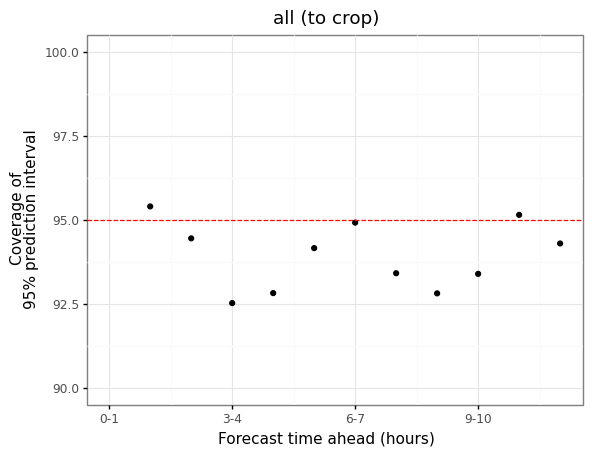

<ggplot: (8788766167897)>

In [45]:
(
    p9.ggplot(conf_res,p9.aes(x="dt0",y="cov95")) +
    p9.geom_point() +
    p9.geom_hline(yintercept=0.95,linetype="dashed",color="red") +
    p9.labs(x="Forecast time ahead (hours)",
             y="Coverage of\n95% prediction interval",
             title="all (to crop)") +
    p9.theme_bw() +
    p9.coord_cartesian(ylim=(0.9,1.0)) +
    p9.scale_y_continuous(breaks=np.linspace(0.9,1.0,5),labels=np.linspace(0.9,1.0,5)*100) +
    p9.scale_x_continuous(breaks=np.linspace(0,12,5),labels=["0-1","3-4","6-7","9-10","12-13"]) 
)

In [46]:
N = 12
max_t = 12
conf_res_hypo = pd.DataFrame({
    "dt0" : np.linspace(0,max_t-1,N),
    "dt1" : np.linspace(1,max_t,N),
    "cov80" : np.zeros(N),
    "cov95" : np.zeros(N),
    "cov99" : np.zeros(N)
})
for i in range(conf_res_hypo.shape[0]):
    msk = (df_test.msk==0) & (df_test.dt >= conf_res_hypo.dt0[i]) & (df_test.dt < conf_res_hypo.dt1[i]) & (ginv(df_test.glc_dt) < 70)
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    conf_res_hypo.cov80[i] = res80
    conf_res_hypo.cov95[i] = res95
    conf_res_hypo.cov99[i] = res99

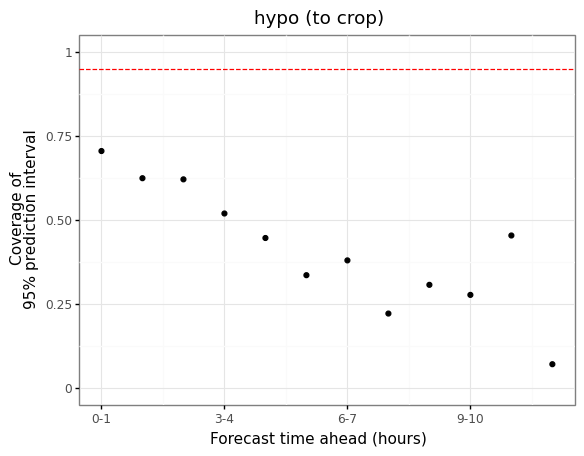

<ggplot: (8788766277833)>

In [47]:
(
    p9.ggplot(conf_res_hypo,p9.aes(x="dt0",y="cov95")) +
    p9.geom_point() +
    p9.geom_hline(yintercept=0.95,linetype="dashed",color="red") +
    p9.labs(x="Forecast time ahead (hours)",
             y="Coverage of\n95% prediction interval",
             title="hypo (to crop)") +
    p9.theme_bw() +
    p9.coord_cartesian(ylim=(0.0,1.0)) +
    #plt9.scale_y_continuous(breaks=np.linspace(0.9,1.0,5),labels=np.linspace(0.9,1.0,5)*100) +
    p9.scale_x_continuous(breaks=np.linspace(0,12,5),labels=["0-1","3-4","6-7","9-10","12-13"]) 
)

In [48]:
N = 12
max_t = 12
conf_res_hyper = pd.DataFrame({
    "dt0" : np.linspace(0,max_t-1,N),
    "dt1" : np.linspace(1,max_t,N),
    "cov80" : np.zeros(N),
    "cov95" : np.zeros(N),
    "cov99" : np.zeros(N)
})
for i in range(conf_res_hyper.shape[0]):
    msk = (df_test.msk==0) & (df_test.dt >= conf_res_hyper.dt0[i]) & (df_test.dt < conf_res_hyper.dt1[i]) & (ginv(df_test.glc_dt) > 180)
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    conf_res_hyper.cov80[i] = res80
    conf_res_hyper.cov95[i] = res95
    conf_res_hyper.cov99[i] = res99

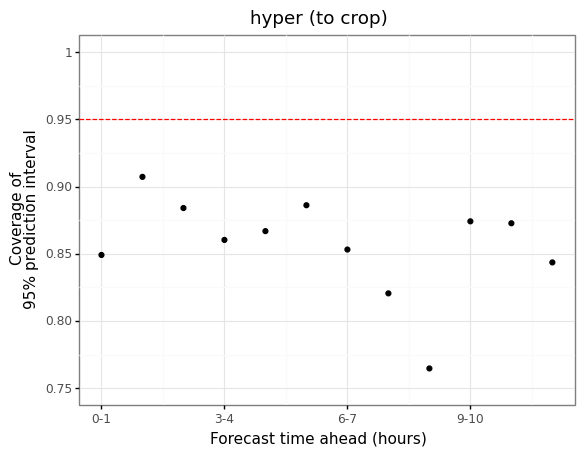

<ggplot: (8788766349141)>

In [49]:
(
    p9.ggplot(conf_res_hyper,p9.aes(x="dt0",y="cov95")) +
    p9.geom_point() +
    p9.geom_hline(yintercept=0.95,linetype="dashed",color="red") +
    p9.labs(x="Forecast time ahead (hours)",
             y="Coverage of\n95% prediction interval",
             title="hyper (to crop)") +
    p9.theme_bw() +
    p9.coord_cartesian(ylim=(0.75,1.0)) +
    #plt9.scale_y_continuous(breaks=np.linspace(0.9,1.0,5),labels=np.linspace(0.9,1.0,5)*100) +
    p9.scale_x_continuous(breaks=np.linspace(0,12,5),labels=["0-1","3-4","6-7","9-10","12-13"]) 
)

In [50]:
df_test["glc_dt_locf"] = df_test.glc
df_test.loc[df_test.glc_dt_locf == 0,'glc_dt_locf'] = np.NaN
df_test["glc_dt_locf"] = df_test.groupby('icustay_id')["glc_dt_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[df_test.msk==0]) - ginv(df_test.glc_dt[df_test.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

RMSE (locf): 44.0801


In [51]:
res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[df_test.msk==0]) - ginv(df_test.glc_dt[df_test.msk==0]))**2))
print("RMSE (model): {:05.4f}".format(res_rmse_model))

RMSE (model): 40.6986


In [52]:
N = 12
max_t = 12
rmse_res = pd.DataFrame({
    "dt0" : np.linspace(0,max_t-1,N),
    "dt1" : np.linspace(1,max_t,N),
    "odernn" : np.zeros(N),
    "locf" : np.zeros(N)
})
for i in range(rmse_res.shape[0]):
    msk = (df_test.msk==0) & (df_test.dt >= rmse_res.dt0[i]) & (df_test.dt < rmse_res.dt1[i]) 
    res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
    res_rmse_odernn = math.sqrt(np.mean((ginv(df_test.mu[msk]) - ginv(df_test.glc_dt[msk]))**2))
    rmse_res.odernn[i] = res_rmse_odernn
    rmse_res.locf[i] = res_rmse_locf

In [53]:
rmse_res.index = pd.MultiIndex.from_arrays(rmse_res[['dt0', 'dt1']].values.T, names=['dt0', 'dt1'])

In [54]:
rmse_res = rmse_res.loc[:,["odernn","locf"]].stack()

In [55]:
rmse_res = pd.concat((rmse_res.index.to_frame().reset_index(drop=True),rmse_res.reset_index(drop=True)),axis=1)

In [56]:
rmse_res = rmse_res.rename(columns={2:"model",0:"rmse"})

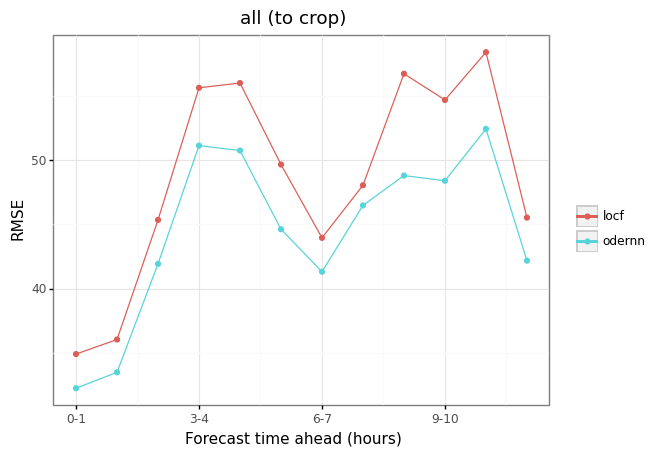

<ggplot: (8788766301937)>

In [57]:
(
    p9.ggplot(rmse_res,p9.aes(x="dt0",y="rmse",color="factor(model)")) +
    p9.geom_point() +
    p9.geom_line() +
    p9.labs(x="Forecast time ahead (hours)",
             y="RMSE",
             title="all (to crop)") +
    p9.theme_bw() +
    p9.scale_color_discrete(name=" ") +
    #plt9.coord_cartesian(ylim=(0.75,1.0)) +
    #plt9.scale_y_continuous(breaks=np.linspace(0.9,1.0,5),labels=np.linspace(0.9,1.0,5)*100) +
    p9.scale_x_continuous(breaks=np.linspace(0,12,5),labels=["0-1","3-4","6-7","9-10","12-13"]) 
)

In [58]:
prob_test = scipy.stats.norm(df_test.loc[df_test.msk==0,"mu"], df_test.loc[df_test.msk==0,"sig"]).cdf(df_test.loc[df_test.msk==0,"glc_dt"])

In [59]:
# a forecast is overdispersed if var < 0.8333 and underdispersed if var > 0.8333
print(1/12)
varF = np.var(prob_test)
print('variance of probs: {:05.4f}'.format(varF))
if varF > 1/12:
    print("underdispersed")
else: 
    print("overdispersed")

0.08333333333333333
variance of probs: 0.0768
overdispersed


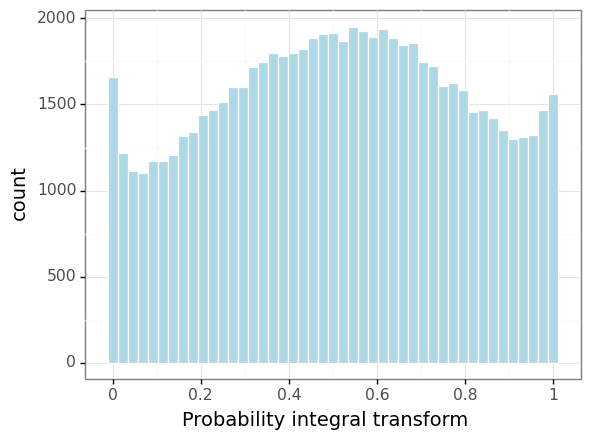

<ggplot: (8788765958389)>

In [60]:
(
    p9.ggplot(pd.DataFrame(prob_test),p9.aes(x="prob_test")) +
    p9.geom_histogram(bins=45,color="white",fill="lightblue") + 
    p9.labs(x="Probability integral transform") +
    p9.scale_x_continuous(breaks=np.linspace(0,1,6)) +
    p9.theme_bw(base_size=14)
)

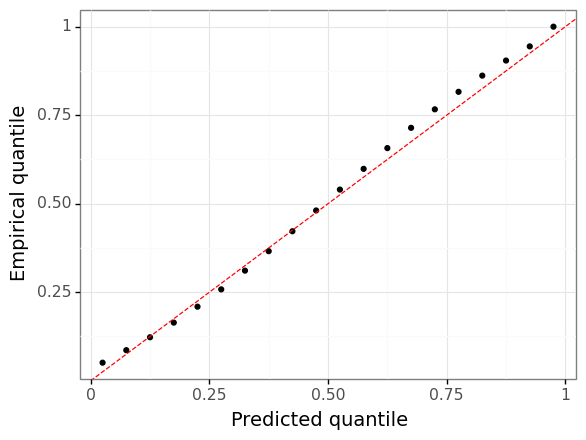

In [61]:
# quantile plot
def calibration_plot(prob_test):
    nbins = 20
    x1s = plt.hist(prob_test,bins=nbins)
    plt.close()
    xbin = np.zeros(nbins)
    for i in range(nbins):
        xbin[i] = (x1s[1][i] + x1s[1][i+1])/2
    qs = np.cumsum(x1s[0])/sum(x1s[0])
    errors = np.sqrt(qs*(1-qs)/sum(x1s[0]))
    df = pd.DataFrame({"predq":xbin,"empq":qs,"error":errors})
    p = (
        p9.ggplot(df,p9.aes(x="predq",y="empq")) +
        p9.geom_point() + 
        p9.theme_bw(base_size=14) +
        p9.labs(x="Predicted quantile",y="Empirical quantile") +
        p9.geom_abline(intercept=0,slope=1,linetype="dashed",color="red")
    )
    fig = p.draw()
    fig.show()
calibration_plot(prob_test)

In [62]:
df_test_input = df_test.loc[df_test.input_hrs > 0].copy()
samp_ids = np.random.choice(df_test_input.icustay_id.unique(),min(100,df_test_input.icustay_id.unique().shape[0]))
df_test_input = df_test_input[df_test_input.icustay_id.isin(samp_ids)]

In [63]:
inputs = np.linspace(0.7,1.0,3)
inputs = np.append(0.0,inputs)
dts = np.linspace(0.0,2.0,5)
for i in range(0,inputs.shape[0]):
    insulin_input = inputs[i]
    df_test_input["input_hrs"] = insulin_input
    for j in range(0,dts.shape[0]):
        df_test_input["timer_dt"] = df_test_input["timer"] + dts[j]
        dl_test_input = DataLoader(MIMICDataset(df_test_input,all_features(),verbose=False),batch_size=128,collate_fn=collate_fn_padd)
        dataloaders = {'test':dl_test_input}
        mu,sig = model.predict(dataloaders["test"])
        df_test_input.loc[df_test_input.msk==0,'mu'+str(i)+str(j)] = mu
        #df_test_input.loc[df_test_input.msk==0,'sig'+str(i)] = sig
        df_test_input.loc[df_test_input.msk==0,'change'+str(i)+str(j)] = ginv(df_test_input.loc[df_test_input.msk==0,'glc']) - ginv(mu)

RuntimeError: input has inconsistent input_size: got 99 expected 25

In [66]:
cols = [col for col in df_test_input if col.startswith('change')]
df_test_input = df_test_input.loc[df_test_input.msk == 0,cols]
nn = df_test_input.shape[0]
df_test_input = df_test_input.stack()

AttributeError: 'int' object has no attribute 'startswith'

In [67]:
df_test_input = pd.concat((df_test_input.index.to_frame().reset_index(drop=True),df_test_input.reset_index(drop=True)),axis=1)
df_test_input.columns = ["id","change","value"]

ValueError: Length mismatch: Expected axis has 124 elements, new values have 3 elements

In [65]:
inputsr = np.repeat(inputs,(nn,))
inputsr = np.tile(inputsr,(dts.shape[0],))
dtsr = np.tile(dts,(nn,))
dtsr = np.tile(dtsr,(inputs.shape[0],))
df_test_input['dt'] = dtsr
df_test_input['input'] = inputsr

TypeError: int() argument must be a string, a bytes-like object or a number, not 'module'

In [68]:
df_test_input

,0,0,subject_id,hadm_id,icustay_id,icu_admissiontime,icu_dischargetime,timer,timer_dt,glc,...,dt,mu,sig,lower80,upper80,lower95,upper95,lower99,upper99,glc_dt_locf
0,0,1694,75851,116748,202447,0.0,26.38,3.90,3.90,-0.028988,...,0.50,-0.070067,0.136261,-0.244693,0.104559,-0.337134,0.197000,-0.518439,0.378305,-0.028988
1,1,1695,75851,116748,202447,0.0,26.38,4.40,4.40,-0.188052,...,1.27,-0.233870,0.191226,-0.478937,0.011196,-0.608667,0.140927,-0.863106,0.395366,-0.188052
2,2,1696,75851,116748,202447,0.0,26.38,5.67,5.67,-0.316670,...,1.75,-0.347764,0.215156,-0.623498,-0.072031,-0.769463,0.073934,-1.055741,0.360213,-0.316670
3,3,1697,75851,116748,202447,0.0,26.38,7.42,7.42,0.035091,...,1.25,-0.037809,0.181318,-0.270178,0.194560,-0.393186,0.317568,-0.634442,0.558823,0.035091
4,4,1698,75851,116748,202447,0.0,26.38,8.67,8.67,-0.081830,...,0.65,-0.121434,0.151096,-0.315071,0.072203,-0.417576,0.174708,-0.618619,0.375750,-0.081830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,2145,78263,99726,186684,299571,0.0,63.48,53.22,53.22,-0.097455,...,1.93,-0.186668,0.212912,-0.459526,0.086189,-0.603968,0.230631,-0.887260,0.513923,-0.097455
2146,2146,78264,99726,186684,299571,0.0,63.48,55.15,55.15,-0.051293,...,1.07,-0.110453,0.176318,-0.336414,0.115508,-0.456031,0.235125,-0.690633,0.469728,-0.051293
2147,2147,78265,99726,186684,299571,0.0,63.48,56.22,56.22,-0.043803,...,1.00,-0.101396,0.176018,-0.326972,0.124181,-0.446385,0.243594,-0.680589,0.477797,-0.043803
2148,2148,78266,99726,186684,299571,0.0,63.48,57.22,57.22,-0.066445,...,1.00,-0.123172,0.173118,-0.345032,0.098688,-0.462478,0.216134,-0.692823,0.446479,-0.066445


In [69]:
(
    p9.ggplot(df_test_input,p9.aes(x="dt",y="value",color="factor(input)")) +
    #p9.geom_line() +
    p9.geom_smooth() +
    p9.coord_cartesian(ylim=(0,10)) +
    p9.theme_bw(base_size=14)
)

PlotnineError: "Could not evaluate the 'y' mapping: 'value' (original error: name 'value' is not defined)"

In [70]:
df_test_input.loc[(df_test_input.input==0) & (df_test_input.id == 325)]

AttributeError: 'DataFrame' object has no attribute 'input'

In [71]:
df_test_input["id1"] = np.repeat(range(0,8984),5)

ValueError: Length of values (44920) does not match length of index (2150)

In [72]:
(
    p9.ggplot(df_test_input.loc[df_test_input.input==0][0:200],p9.aes(x="dt",y="-value")) +
    p9.geom_line(p9.aes(group="id1"),alpha=0.2) +
    p9.theme_bw(base_size=14) +
    p9.geom_smooth(color="blue")+
    p9.facet_wrap("input")+
    p9.labs(x="Forecast time ahead (hours)",
            y="Forecast change\nin blood glucose (mg/dL)",
           title="no insulin")
)

AttributeError: 'DataFrame' object has no attribute 'input'

In [73]:
(
    p9.ggplot(df_test_input.loc[(df_test_input.input >= 0.7) & (df_test_input.input < 0.8)][0:200],p9.aes(x="dt",y="-value")) +
    p9.geom_line(p9.aes(group="id1"),alpha=0.2) +
    p9.theme_bw(base_size=14) +
    p9.geom_smooth(color="blue")+
    p9.facet_wrap("input")+
    p9.labs(x="Forecast time ahead (hours)",
            y="Forecast change\nin blood glucose (mg/dL)",
           title="0.75 std insulin")
)

AttributeError: 'DataFrame' object has no attribute 'input'

In [74]:
(
    p9.ggplot(df_test_input.loc[(df_test_input.input >= 0.85) & (df_test_input.input < 1.0)],p9.aes(x="dt",y="-value")) +
    p9.geom_line(p9.aes(group="id1"),alpha=0.2) +
    p9.theme_bw(base_size=14) +
    p9.geom_smooth(color="blue")+
    p9.facet_wrap("input")+
    p9.labs(x="Forecast time ahead (hours)",
            y="Forecast change\nin blood glucose (mg/dL)",
           title="0.85 std insulin")
)

AttributeError: 'DataFrame' object has no attribute 'input'

In [75]:
df_test['change_mgdl'] = ginv(df_test.loc[df_test.msk==0].mu) - ginv(df_test.loc[df_test.msk==0].glc)

In [76]:
df_test['mu_inv'] = ginv(df_test['mu'])
df_test['glc_inv'] = ginv(df_test['glc'])
df_test['glc_dt_inv'] = ginv(df_test['glc_dt'])

In [77]:
df_test.loc[df_test.icustay_id == 299957,["timer","timer_dt","glc_inv","mu_inv","glc_dt_inv","msk","input_hrs"]]

,timer,timer_dt,glc_inv,mu_inv,glc_dt_inv,msk,input_hrs
78531,0.48,1.28,111.0,112.484184,112.0,0,0.000000
78532,1.28,2.43,112.0,108.723450,148.0,0,0.720721
78533,2.43,3.30,148.0,141.180786,137.0,0,0.821822
78534,3.30,4.57,137.0,130.039703,93.0,0,0.821822
78535,4.57,5.30,93.0,92.471214,87.0,0,0.713714
78536,5.30,5.48,87.0,NaN,NaN,1,0.713714
78537,5.48,6.52,87.0,86.941315,164.0,0,0.702703
78538,6.52,7.37,164.0,154.818436,106.0,0,0.871491
78539,7.37,8.37,106.0,103.573265,118.0,0,0.833964
78540,8.37,9.30,118.0,113.595627,88.0,0,0.871491


/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2330 rows containing missing values.


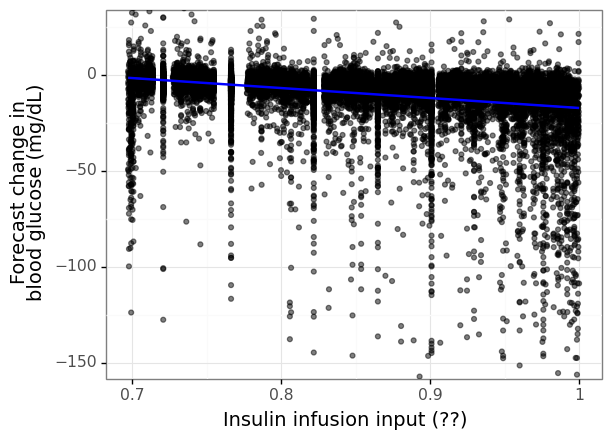

<ggplot: (8788756756625)>

In [78]:
(
    p9.ggplot(df_test.loc[df_test.input_hrs>0],p9.aes(x="input_hrs",y="change_mgdl"))+
    p9.geom_point(alpha=0.5) +
    p9.geom_smooth(color="blue") +
    p9.coord_cartesian(ylim=(-150,25))+
    p9.labs(x="Insulin infusion input (??)",y="Forecast change in\nblood glucose (mg/dL)") +
    p9.theme_bw(base_size=14)
)